# Investment and Trading Capstone Project
## Build a Stock Price Indicator

## 1. Introduction
Financial institutions around the world are trading in billions of dollars on a daily basis. Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades.  A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.

In this project, I will be building a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates. Note that the inputs will contain multiple metrics, such as opening price (Open), highest price the stock traded at (High), how many stocks were traded (Volume) and closing price adjusted for stock splits and dividends (Adjusted Close); I will be predicting the Adjusted Close price.

### Install and import relevant libraries

In [23]:
# imports

import numpy as np
import pandas as pd
#from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython import display
import seaborn as sns
%matplotlib inline

#import functions
import plotting

from datetime import datetime,date

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.metrics import mean_squared_error
from keras.layers.recurrent import LSTM

# Needed to help our plots look cleaner with plotly 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
init_notebook_mode(connected=True)


## 2. Exploratory Analysis
In this section we would be getting the data, view the data and compute some statistics and plots to understand the data very well before we start the modelling process.
### Getting the Data
The data I will be using for the project is from [yahoo finance](https://finance.yahoo.com/).

In [24]:
# https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e
# https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/

# Install yfinance
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [25]:
# Download stock data then export as CSV

import yfinance as yfin

#tickes are S&P 500, Apple, Microsoft, Amazon, Johnson & Johnson, Pfizer, Ford and Google
tickers = ("SPY", "AAPL", "MSFT", "AMZN", "JNJ", "PFE", "F", "GOOGL") 

start = "2001-01-01"
end = '2021-08-17'

fin_data = yfin.download(tickers, start, end) #download yahoo finance data for specific dates

fin_data.to_csv('./data/fin_data.csv') #convert data to csv

[*********************100%***********************]  8 of 8 completed


### View the Data

In [27]:
#check the dimensions of the data
fin_data.shape

(5188, 48)

In [28]:
#view the first 5 rows of the data
fin_data.head()

Adj Close                                                  \
                AAPL     AMZN          F GOOGL        JNJ       MSFT   
Date                                                                   
2001-01-02  0.228070  13.8750  13.328902   NaN  29.894279  13.716833   
2001-01-03  0.251069  17.5625  13.774347   NaN  28.941776  15.159673   
2001-01-04  0.261610  15.5000  14.768012   NaN  28.318979  15.317790   
2001-01-05  0.251069  14.5625  14.391103   NaN  28.685331  15.535211   
2001-01-08  0.253944  14.9375  14.048461   NaN  28.648705  15.475909   

                                     Close           ...       Open  \
                  PFE        SPY      AAPL     AMZN  ...        PFE   
Date                                                 ...              
2001-01-02  21.071360  87.268913  0.265625  13.8750  ...  43.228176   
2001-01-03  19.900730  91.460861  0.292411  17.5625  ...  43.643265   
2001-01-04  19.101274  90.476395  0.304688  15.5000  ...  41.627136   
2001-01-05  19.358248  87.522957  0.292411  14.5625  ...  40.322582   
2001-01-08  19.129835  88.200439  0.295759  14.9375  ...  40.796963   

                          Volume                                      \
                  SPY       AAPL      AMZN         F GOOGL       JNJ   
Date                                                                   
2001-01-02  132.00000  452312000   9203500   5226500   NaN   8855200   
2001-01-03  128.31250  817073600  14680400  11157800   NaN  11326000   
2001-01-04  134.93750  739396000  10620500  14896200   NaN  12941200   
2001-01-05  133.46875  412356000   8798800   6710900   NaN   9277200   
2001-01-08  129.87500  373699200  10444700   5900300   NaN   5520200   

                                           
                 MSFT       PFE       SPY  
Date                                       
2001-01-02   82413200  11231108   8737500  
2001-01-03  135962200  23756633  19431600  
2001-01-04  112397000  34849983   9219000  
2001-01-05   93414600  19097637  12911400  
2001-01-08   79817600  14593684   6625300  

[5 rows x 48 columns]

In [29]:
#view the last 5 values of the data
fin_data.tail()

Adj Close                                               \
                  AAPL         AMZN      F        GOOGL         JNJ   
Date                                                                  
2021-08-10  145.600006  3320.679932  13.82  2736.139893  173.770004   
2021-08-11  145.860001  3292.110107  13.93  2725.580078  173.800003   
2021-08-12  148.889999  3303.500000  13.90  2743.879883  175.199997   
2021-08-13  149.100006  3293.969971  13.59  2754.550049  176.250000   
2021-08-16  151.119995  3298.989990  13.46  2766.189941  177.839996   

                                                    Close               ...  \
                  MSFT        PFE         SPY        AAPL         AMZN  ...   
Date                                                                    ...   
2021-08-10  285.892700  48.189999  442.679993  145.600006  3320.679932  ...   
2021-08-11  286.401733  46.310001  443.779999  145.860001  3292.110107  ...   
2021-08-12  289.256256  47.240002  445.109985  148.889999  3303.500000  ...   
2021-08-13  292.290436  48.480000  445.920013  149.100006  3293.969971  ...   
2021-08-16  294.037109  48.910000  446.970001  151.119995  3298.989990  ...   

                 Open                 Volume                                \
                  PFE         SPY       AAPL     AMZN         F      GOOGL   
Date                                                                         
2021-08-10  46.200001  442.609985   69023100  2412600  32120800   970700.0   
2021-08-11  47.779999  443.820007   48493500  2947200  42795600   767600.0   
2021-08-12  46.500000  443.619995   72282600  2314100  38547900   825300.0   
2021-08-13  47.410000  445.589996   59318800  2052800  44915500   797000.0   
2021-08-16  48.230000  444.529999  103296000  3319700  38664300  1119200.0   

                                                   
                JNJ      MSFT       PFE       SPY  
Date                                               
2021-08-10  3678300  18616600  81189400  43339300  
2021-08-11  4221300  13955900  50878200  44034300  
2021-08-12  4300400  14561300  29676400  38909400  
2021-08-13  5881600  18231400  35341200  39388300  
2021-08-16  4782800  22507600  38045800  73740000  

[5 rows x 48 columns]

In [30]:
#check if there are missing values for each type of stock
fin_data.isnull().sum()

Adj Close  AAPL       0
           AMZN       0
           F          0
           GOOGL    910
           JNJ        0
           MSFT       0
           PFE        0
           SPY        0
Close      AAPL       0
           AMZN       0
           F          0
           GOOGL    910
           JNJ        0
           MSFT       0
           PFE        0
           SPY        0
High       AAPL       0
           AMZN       0
           F          0
           GOOGL    910
           JNJ        0
           MSFT       0
           PFE        0
           SPY        0
Low        AAPL       0
           AMZN       0
           F          0
           GOOGL    910
           JNJ        0
           MSFT       0
           PFE        0
           SPY        0
Open       AAPL       0
           AMZN       0
           F          0
           GOOGL    910
           JNJ        0
           MSFT       0
           PFE        0
           SPY        0
Volume     AAPL       0
           AMZN 

Google has some missing values, and we will use the `fillna` method to resolve the missing values.

In [31]:
# handing missing values
fin_data.fillna(method='ffill', inplace = True) # use front fill method
fin_data.fillna(method='bfill', inplace = True) # use back fill method

In [32]:
#check to see if there are still any missing values
fin_data.isnull().sum()

Adj Close  AAPL     0
           AMZN     0
           F        0
           GOOGL    0
           JNJ      0
           MSFT     0
           PFE      0
           SPY      0
Close      AAPL     0
           AMZN     0
           F        0
           GOOGL    0
           JNJ      0
           MSFT     0
           PFE      0
           SPY      0
High       AAPL     0
           AMZN     0
           F        0
           GOOGL    0
           JNJ      0
           MSFT     0
           PFE      0
           SPY      0
Low        AAPL     0
           AMZN     0
           F        0
           GOOGL    0
           JNJ      0
           MSFT     0
           PFE      0
           SPY      0
Open       AAPL     0
           AMZN     0
           F        0
           GOOGL    0
           JNJ      0
           MSFT     0
           PFE      0
           SPY      0
Volume     AAPL     0
           AMZN     0
           F        0
           GOOGL    0
           JNJ      0
          

Finally, we have no missing values. We will now check some descriptive statistics of the data.

In [33]:
#view descriptive statistics of adjusted close process of the stocks
fin_data[['Adj Close']].describe()

Adj Close                                                      \
              AAPL         AMZN            F        GOOGL          JNJ   
count  5188.000000  5188.000000  5188.000000  5188.000000  5188.000000   
mean     21.900669   577.917316     8.370549   518.120428    69.460896   
std      30.460096   863.985743     2.845221   515.504747    39.212701   
min       0.201162     5.970000     0.854121    50.055054    24.480927   
25%       1.985933    43.642501     6.160183   171.084839    39.583880   
50%      10.597627   182.349998     8.706611   297.302307    47.881804   
75%      27.504356   720.100006    10.269930   768.102509   100.104258   
max     151.119995  3731.409912    17.018152  2766.189941   177.839996   

                                              
              MSFT          PFE          SPY  
count  5188.000000  5188.000000  5188.000000  
mean     50.051573    19.894595   150.217562  
std      56.825684     8.496701    87.026451  
min      11.532787     6.922607    53.155308  
25%      19.017385    13.123518    86.088608  
50%      22.604842    17.170915   109.507298  
75%      50.440979    25.980277   190.648849  
max     294.037109    48.910000   446.970001

In [34]:
# view general info
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5188 entries, 2001-01-02 to 2021-08-16
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, AAPL)   5188 non-null   float64
 1   (Adj Close, AMZN)   5188 non-null   float64
 2   (Adj Close, F)      5188 non-null   float64
 3   (Adj Close, GOOGL)  5188 non-null   float64
 4   (Adj Close, JNJ)    5188 non-null   float64
 5   (Adj Close, MSFT)   5188 non-null   float64
 6   (Adj Close, PFE)    5188 non-null   float64
 7   (Adj Close, SPY)    5188 non-null   float64
 8   (Close, AAPL)       5188 non-null   float64
 9   (Close, AMZN)       5188 non-null   float64
 10  (Close, F)          5188 non-null   float64
 11  (Close, GOOGL)      5188 non-null   float64
 12  (Close, JNJ)        5188 non-null   float64
 13  (Close, MSFT)       5188 non-null   float64
 14  (Close, PFE)        5188 non-null   float64
 15  (Close, SPY)        5188 non-null   f

In [35]:
# View the maximum close date of stocks
def max_close(stocks,df):
    """ This calculates and returns the maximum closing value of a specific stock"""
    return df['Close'][stocks].max() # computes and returns the maximum closing stock value

In [36]:
# test the above function with specific stocks
def test_max():
    """ This tests the max_close function"""
    for stocks in ["SPY", "AAPL", "MSFT", "AMZN", "JNJ", "PFE", "F", "GOOGL"]:
        print("Maxiumum Closing Value for {} is {}".format(stocks, max_close(stocks,fin_data)))

test_max()        
#if __name__ == "__main__" :
#    test_()

Maxiumum Closing Value for SPY is 446.9700012207031
Maxiumum Closing Value for AAPL is 151.1199951171875
Maxiumum Closing Value for MSFT is 294.6000061035156
Maxiumum Closing Value for AMZN is 3731.409912109375
Maxiumum Closing Value for JNJ is 177.83999633789062
Maxiumum Closing Value for PFE is 48.90999984741211
Maxiumum Closing Value for F is 30.709999084472656
Maxiumum Closing Value for GOOGL is 2766.18994140625


In [37]:
# calculate the mean volume for the stocks
def mean_vol(stocks,df):
    """ This calculates and returns the minimum volume of a specific stock"""
    return df['Volume'][stocks].mean() # computes and returns the minimum volume of a stock

In [38]:
# test the above function with specific stocks
def test_mean():
    """ This tests the max_close function"""
    for stocks in ["SPY", "AAPL", "MSFT", "AMZN", "JNJ", "PFE", "F", "GOOGL"]:
        print("Mean Volume for {} is {}".format(stocks, mean_vol(stocks,fin_data)))

test_mean()        

Mean Volume for SPY is 115524061.79645336
Mean Volume for AAPL is 433155810.1387818
Mean Volume for MSFT is 52421926.21434078
Mean Volume for AMZN is 6273994.872783346
Mean Volume for JNJ is 9222071.395528141
Mean Volume for PFE is 33343766.369699307
Mean Volume for F is 41955425.15420201
Mean Volume for GOOGL is 13289167.038164996


### Plotting stock prices

In [39]:
# Plot function for the Adjusted closing value
def plot_adj(df,title,stocks,y=0):
        ax = df['Adj Close'][stocks].plot(title=title, figsize=(16,8), ax=None)
        ax.set_xlabel("Date")
        ax.set_ylabel("Stock Price")
        ax.axhline(y=y,color='black')
        ax.legend(stocks, loc='upper left')
        plt.show()

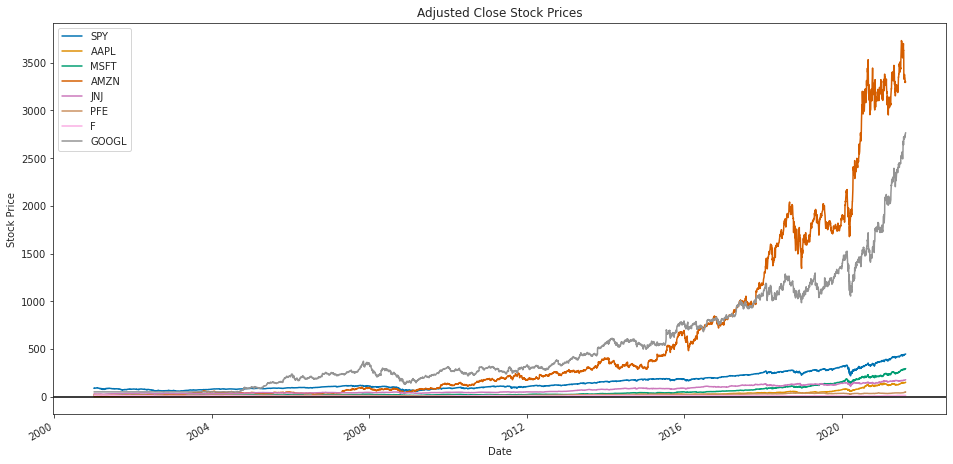

In [40]:
# View the plot of Adjusted close
stocks = ["SPY", "AAPL", "MSFT", "AMZN", "JNJ", "PFE", "F", "GOOGL"]
plot_adj(fin_data,"Adjusted Close Stock Prices",stocks)

From the plot above, we can see that Amazon and Google has the highest growth. This could be as a result of the increase in useage of these companies world wide, but let us normalize the data before we make that conclusion. I will explore more features in the dataset before normalizing it.

In [41]:
# Plot function for the High prices
def plot_high(df,title,stocks,y=0):
        ax = df['High'][stocks].plot(title=title, figsize=(16,8), ax = None)
        ax.set_xlabel("Date")
        ax.set_ylabel("Stock Price")
        ax.axhline(y=y,color='black')
        ax.legend(stocks, loc='upper left')
        plt.show()

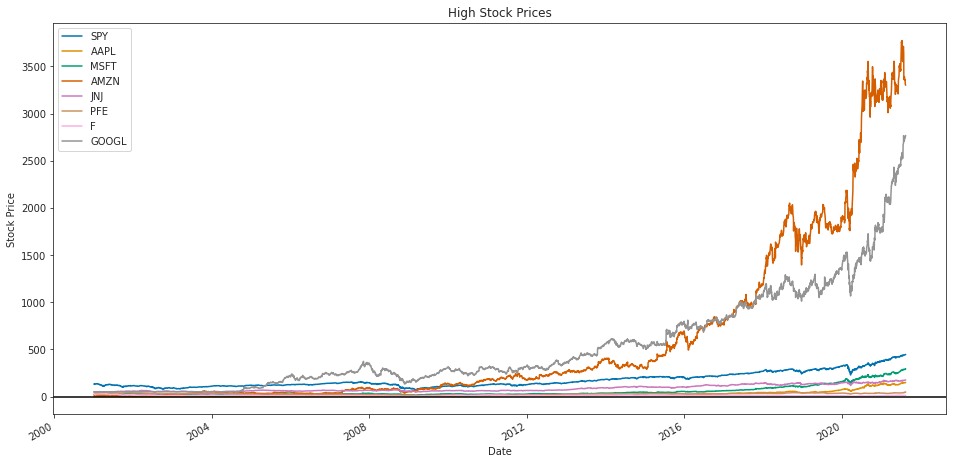

In [42]:
# View the plot of high stock prices
stocks = ["SPY", "AAPL", "MSFT", "AMZN", "JNJ", "PFE", "F", "GOOGL"]
title = "High Stock Prices"
plot_high(fin_data,title,stocks)

Similar to the adjusted value plot, we can see high stock prices for Amazon and Google. 

In [43]:
#view only google Adjusted close price
fin_data['Adj Close']['GOOGL']

Date
2001-01-02      50.220219
2001-01-03      50.220219
2001-01-04      50.220219
2001-01-05      50.220219
2001-01-08      50.220219
                 ...     
2021-08-10    2736.139893
2021-08-11    2725.580078
2021-08-12    2743.879883
2021-08-13    2754.550049
2021-08-16    2766.189941
Name: GOOGL, Length: 5188, dtype: float64

In [44]:
# view only google and amazon Adjusted close price
fin_data['Adj Close'][['GOOGL', 'AMZN']]

,GOOGL,AMZN
Date,,
2001-01-02,50.220219,13.875000
2001-01-03,50.220219,17.562500
2001-01-04,50.220219,15.500000
2001-01-05,50.220219,14.562500
2001-01-08,50.220219,14.937500
...,...,...
2021-08-10,2736.139893,3320.679932
2021-08-11,2725.580078,3292.110107
2021-08-12,2743.879883,3303.500000


In [45]:
# view all stocks adjusted close prices for amazon and google from Jan 2010 to Aug 2021
fin_data['Adj Close'].loc['2010-01-01':'2021-08-17', ['AMZN', 'GOOGL']]

,AMZN,GOOGL
Date,,
2010-01-04,133.899994,313.688690
2010-01-05,134.690002,312.307312
2010-01-06,132.250000,304.434448
2010-01-07,130.000000,297.347351
2010-01-08,133.520004,301.311310
...,...,...
2021-08-10,3320.679932,2736.139893
2021-08-11,3292.110107,2725.580078
2021-08-12,3303.500000,2743.879883


In [46]:
# view all stocks adjusted close price from Jan 2010 to Aug 2021
fin_data['Adj Close'].loc['2010-01-01':'2021-08-17']

,AAPL,AMZN,F,GOOGL,JNJ,MSFT,PFE,SPY
Date,,,,,,,,
2010-01-04,6.562591,133.899994,6.968545,313.688690,46.011322,23.948717,11.590302,90.493996
2010-01-05,6.573935,134.690002,7.429503,312.307312,45.477795,23.956453,11.424991,90.733574
2010-01-06,6.469369,132.250000,7.707428,304.434448,45.847706,23.809435,11.388254,90.797455
2010-01-07,6.457407,130.000000,7.904015,297.347351,45.520481,23.561821,11.345395,91.180725
2010-01-08,6.500339,133.520004,7.924348,301.311310,45.676979,23.724321,11.437235,91.484131
...,...,...,...,...,...,...,...,...
2021-08-10,145.600006,3320.679932,13.820000,2736.139893,173.770004,285.892700,48.189999,442.679993
2021-08-11,145.860001,3292.110107,13.930000,2725.580078,173.800003,286.401733,46.310001,443.779999
2021-08-12,148.889999,3303.500000,13.900000,2743.879883,175.199997,289.256256,47.240002,445.109985


In [47]:
# create function to plot data
def plot_data1(df,stocks,title,ylabel='Stock Price',y=0):
    """This funtion plots stock prices"""
    ax = df.plot(title=title, figsize=(16,8), ax=None, fontsize=2)
    ax.set_xlabel("Date")
    ax.set_label(ylabel)
    ax.axhline(y=y,color='black')
    ax.legend(stocks, loc='upper left')
    plt.show()

In [48]:
# create function to plot selected stocks
def selected_plot(df, columns,stocks, start_idx, end_idx):
    """This function plots specific stocks over a given date range"""
    plot_data1(df[columns].loc[start_idx:end_idx, stocks],stocks, title="Plot for selected Stocks")

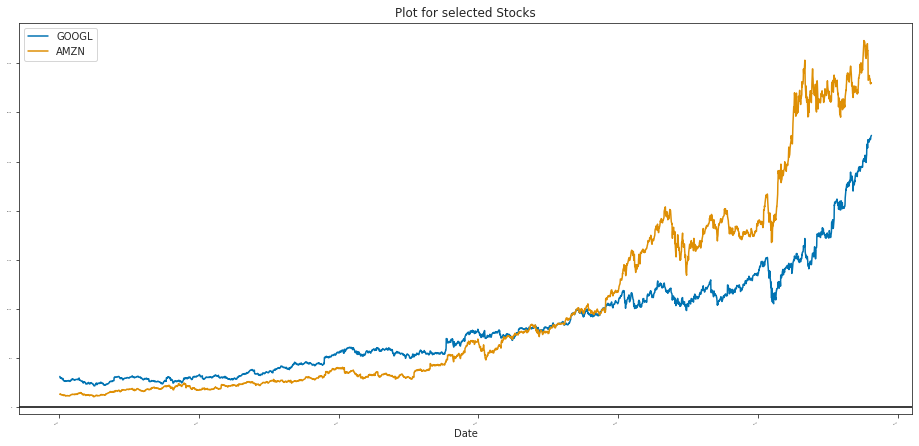

In [49]:
# create function to plot data based on specific columns, symbols, and date ranges
def test_select():
    """This function plots stock data based on specific columns, symbols, and date ranges """
    # specify columns to plot and stock symbols
    columns = 'Adj Close'
    stocks = ['GOOGL', 'AMZN']  
        
    # Get stock data
    df = fin_data

    # Slice and plot
    selected_plot(df, columns, stocks, '2010-01-01', '2021-08-17')
    
test_select()  # run the plot function  

### Normalizing the data
We want to know how the different types of stocks went up and down with respect to the others. In order to do this, we will normalize the data. We do this by dividing the values of each column by day one to ensure that each stock starts with ${$1}$.

In [50]:
def plot_data2(df,stocks,title='Stock Prices',ylabel="Stock Price",y=0, start='2001-01-01', end ='2021-08-17'):
    
    """ This function creates a plot of adjusted close stock prices
    inputs:
    df - dataframe
    title - plot title
    stocks - the stock symbols of each company
    ylabel - y axis label
    y - horizontal line(integer)
    output: the plot of adjusted close stock prices
    """
    df_new = df[start:end]
    #ax = df_new['Adj Close'][stocks].plot(title=title, figsize=(16,8), ax = None)
    ax = df_new.plot(title=title, figsize=(16,8), ax = None)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel)
    ax.axhline(y=y,color='black')
    ax.legend(stocks, loc='upper left')
    plt.show()

In [51]:
# create function that normalizes the data
def normalize_data(df):
    """ 
    This function normalizes the stock prices using the first row of the dataframe
    input - stock data
    output - normalized stock data
    """
    return df/df.iloc[0,:]    

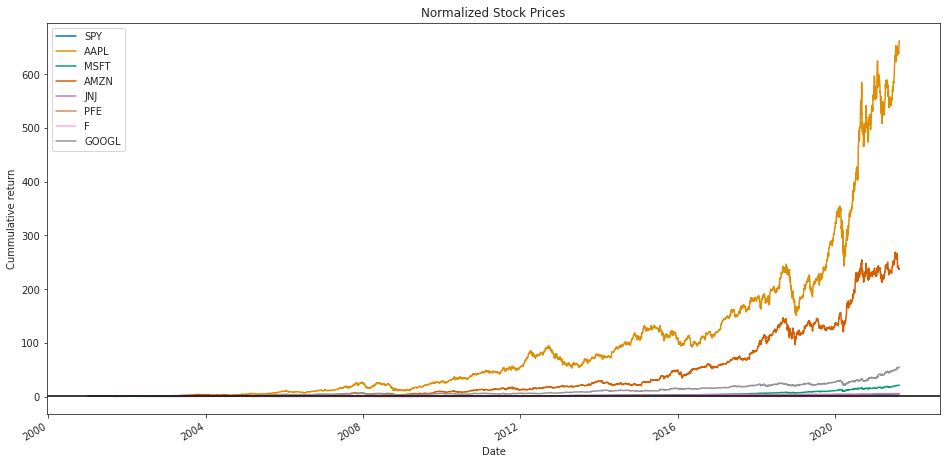

In [52]:
# plot the data with the new normalized data

stocks = ["SPY", "AAPL", "MSFT", "AMZN", "JNJ", "PFE", "F", "GOOGL"]

plot_data2(normalize_data(fin_data['Adj Close'][stocks]),stocks,title = "Normalized Stock Prices", ylabel = 'Cummulative return',y=1)

From the above cummulative return plot, we can see that Apple has the highest return over the years, while Amazon was second and Google third and Microsoft fourth. The growth of Google and Microsoft looks much more stable than Apple and Amazon. Looking at the plot, Apple has alot of volatility and risky stocks especially in recent years.

### Cumulative Return
Let's have a look at how the pandemic affected stock prices for these companies.

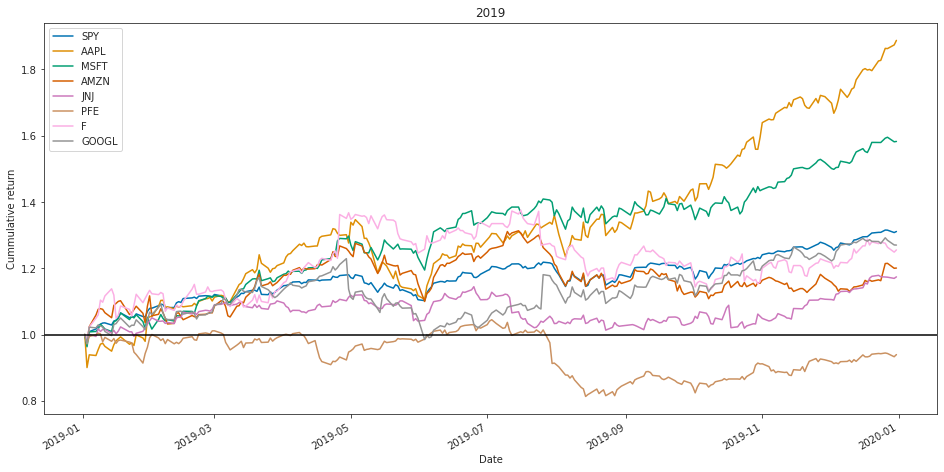

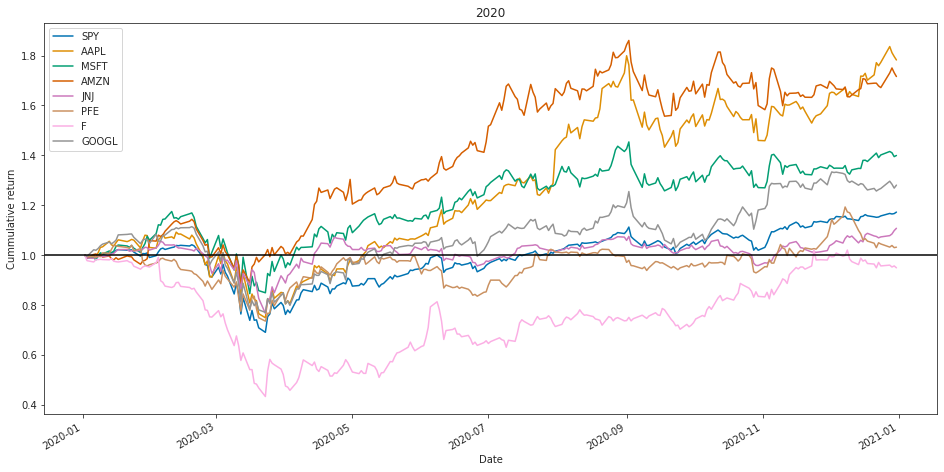

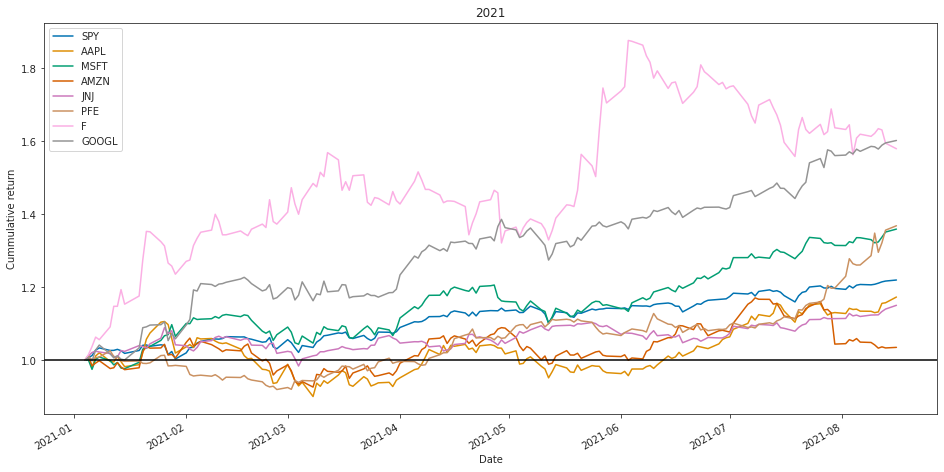

In [53]:
stocks = ["SPY", "AAPL", "MSFT", "AMZN", "JNJ", "PFE", "F", "GOOGL"]

plot_data2(normalize_data(fin_data['Adj Close'][stocks]['2019-01-01':'2019-12-31']), stocks,title = '2019', ylabel = 'Cummulative return',y=1, start='2019-01-01', end = '2019-12-31') #2019
plot_data2(normalize_data(fin_data['Adj Close'][stocks]['2020-01-01':'2020-12-31']), stocks,title = '2020', ylabel = 'Cummulative return',y=1, start='2020-01-01', end = '2020-12-31') #2020
plot_data2(normalize_data(fin_data['Adj Close'][stocks]['2021-01-01':'2021-08-17']), stocks,title = '2021', ylabel = 'Cummulative return',y=1, start='2021-01-01', end = '2021-08-17') #2021

From the above plots, let's take note of the following:

    1. 2019: Before the pandemic, we notice that most of the companies stocks were doing relatively well with Apple and Microsoft taking the lead and Pfizer trailing behind.
    2. 2020: On the onset of the pandemic around Spring, we notice that there was a fall in stock prices for all the companies, but afterwards the technology companies like Amazon, Apple, Microsoft and Google started to grow again. But companies like Pfizer, Ford and S&P 500 did not do very well especially Ford.
    3. 2021: As the vaccine rollout began and the lockdown began to be lifted, we can see significant growth in the stock prices of Ford in particular given that its stock prices which were low in 2020 due to the pandemic. Companies like Google and Microsoft and S&P 500 also grew. Overall there was an improvement in the stock prices of all the companies we considered.

### Computing the Rolling mean and Bollinger Bands
The rolling mean may give us some idea about the true underlying prices of a stock. If there is a significant deviation below or above the rolling mean, it may give us an idea about a potential buying and selling opportunity respectively. The challenge remains to know when this deviation is significant enough to pay attention to it. [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands) is a statistical chart that contains the volatility of a financial instrument over time. `Bollinger` observed that looking at the recent volatility of the stock, if it is very volatile, we might discard the movement above and below the mean. But if it is not very volatile we may want to pay attention to it. He added a band  $2\delta$ (2 standard deviations)  above and below the mean. We would use the rolling standard deviation to help us achieve this.

In [62]:
# compute rolling mean, rolling standard deviation, upper and lower bands

def rolling_stats(df, stocks, type_, window = 20):
    """
    This function computes the rolling mean and Bollinger bands
    inputs : 
    df - dataframe
    stocks - the type of stocks we would be analyzing
    type_ - the price type of the rolling calculation
    window - number of days used to calculate the statistics
    output: 
    rolling mean, rolling standard deviation, upper and lower bands of 2 std each
    """
    
    val = df[(type_,stocks)]
    rolling_mean = df[(type_, stocks)].rolling(window=window).mean()
    rolling_std = df[(type_, stocks)].rolling(window=window).std()
    upper_band = rolling_mean + rolling_std*2
    lower_band = rolling_mean - rolling_std*2
    
    return val, rolling_mean, rolling_std, upper_band, lower_band
    

In [63]:
# plot the rolling mean, rolling standard deviation, upper and lower bands

def rolling_plot(stocks, val, rolling_mean, upper_band, lower_band, title='Rolling mean'):
    """
    This function plots the rolling mean and Bollinger bands
    inputs : 
    stocks - the type of stocks we would be analyzing
    val - value of the stock price type
    rolling_mean - rolling mean
    upper_band - stocks upper band
    lower_band - stocks lower band
    title - plot title
    output: 
    plot of rolling mean, rolling standard deviation, upper and lower bands of 2 std each
    """
    
    ax = rolling_mean.plot(title=title, figsize=(16,8), label='Rolling Mean')
    plt.plot(upper_band, label = 'Upper Band')
    plt.plot(lower_band, label = 'Lower Band')
    plt.plot(val, label = 'Value of Stock')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
    plt.show()
    
    return ax


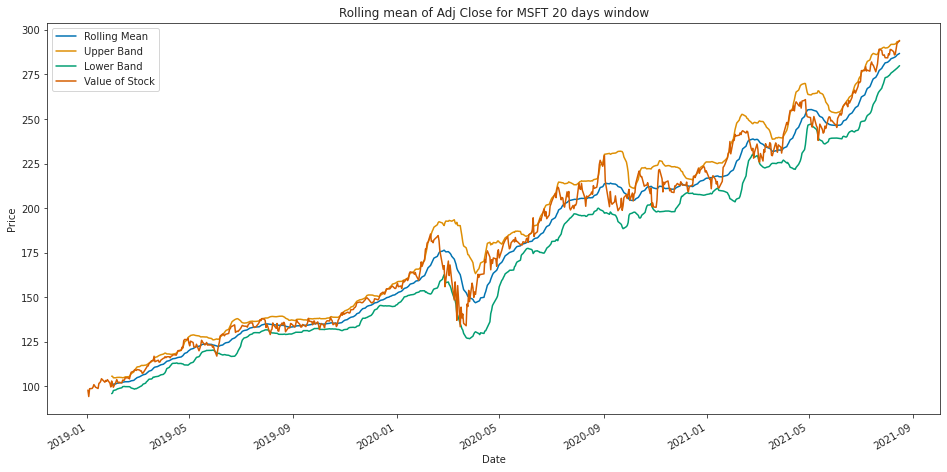

In [56]:
stocks = 'MSFT'
type_ = 'Adj Close'

val, rolling_mean, rolling_std, upper_band, lower_band = rolling_stats(fin_data['2019-01-01':'2021-08-17'], stocks, type_)

rolling_plot(stocks, val, rolling_mean, upper_band, lower_band, title='Rolling mean of {} for {} 20 days window'.format(type_,stocks))
plt.show()

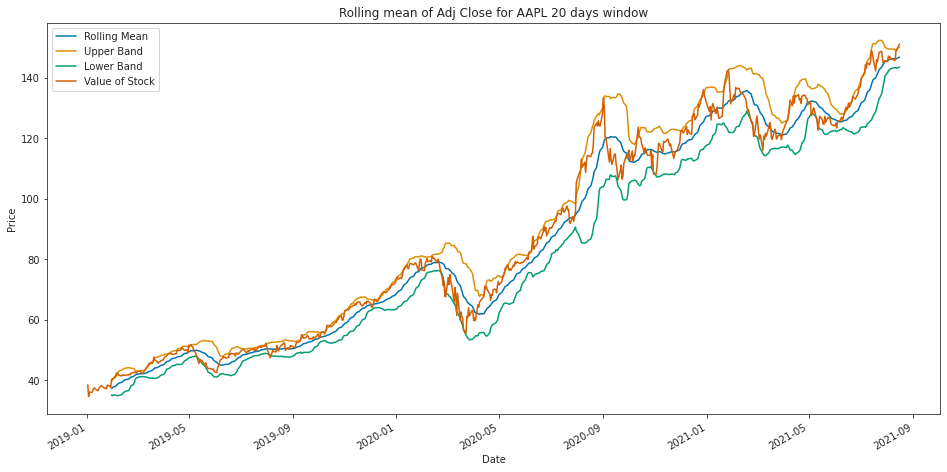

In [64]:
# view rolling statistics for Apple
stocks = 'AAPL'
type_ = 'Adj Close'

val, rolling_mean, rolling_std, upper_band, lower_band = rolling_stats(fin_data['2019-01-01':'2021-08-17'], stocks, type_)

rolling_plot(stocks, val, rolling_mean, upper_band, lower_band, title='Rolling mean of {} for {} 20 days window'.format(type_,stocks))
plt.show()

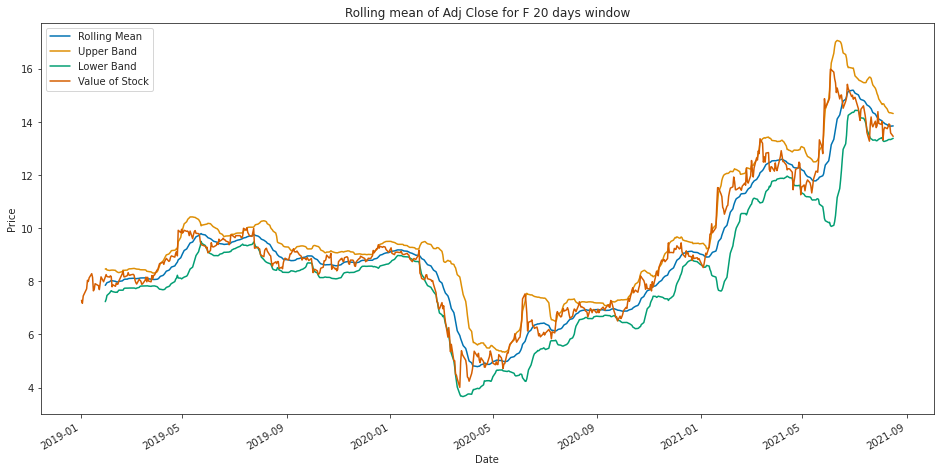

In [65]:
# view rolling statistics for Ford
stocks = 'F'
type_ = 'Adj Close'

val, rolling_mean, rolling_std, upper_band, lower_band = rolling_stats(fin_data['2019-01-01':'2021-08-17'], stocks, type_)

rolling_plot(stocks, val, rolling_mean, upper_band, lower_band, title='Rolling mean of {} for {} 20 days window'.format(type_,stocks))
plt.show()

From the above plots, we can see that the initial values for the rolling mean are missing. This is as a result of the 20 days window period we used at the beginning which had no values. We can also observe that the rolling mean follows the movement of the raw stock prices and it is less spiky. We can also see that Ford has lower stock prices than Microsoft and Apple in 2020. In this data exploration session, I only considered a 20 days window and for 2 standard deviation away from the mean for simplicity. You may want to try computing different windows sizes and standard deviations to see how differently the stock prices behave.

### Computing Daily Returns
Daily returns tells us how much the stock price go up and down on a particular day. We can compute using the following function
$$
DailyReturn = \frac{price(t)}{price(t-1)} -1
$$
where `price(t)` is the price of today's stock and `price(t-1)` is the price of yesterday's stock.

In [66]:
def daily_returns_cal(df,stocks):
    """
    This function computes and returns the daily return values
    input: df (dataframe) and stocks
    output: daily return values
    """
    
    daily_returns = (df[('Adj Close', stocks)][1:]/df[('Adj Close', stocks)][:-1].values) - 1
       
    return daily_returns

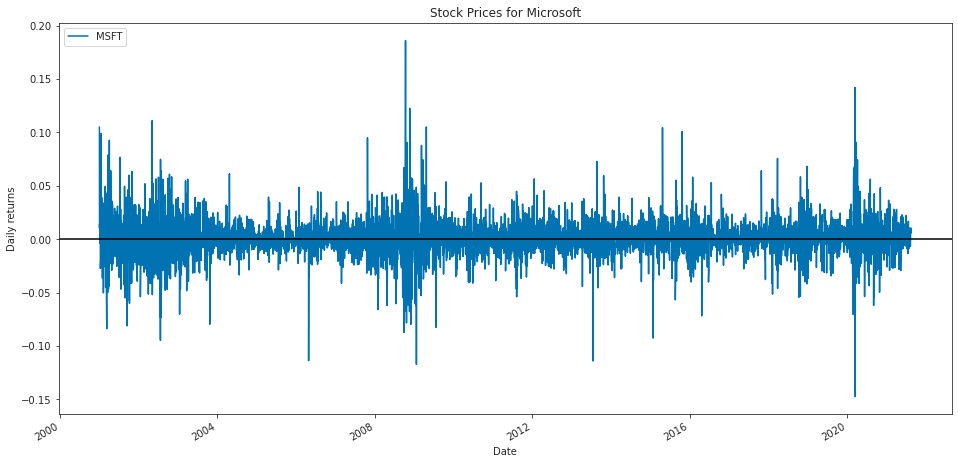

In [67]:
# Daily return of Microsoft
plot_data2(daily_returns_cal(fin_data,'MSFT'),stocks=['MSFT'], ylabel = 'Daily returns',title='Stock Prices for Microsoft',y=0)

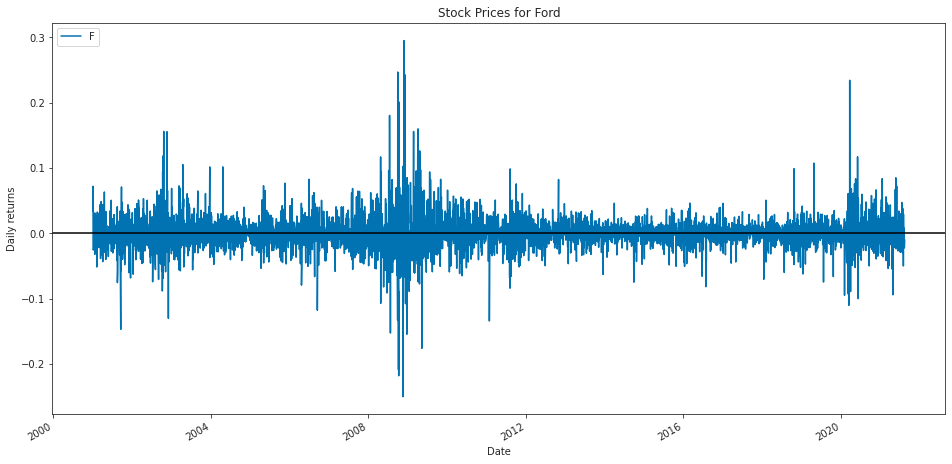

In [68]:
# Daily return of Ford
plot_data2(daily_returns_cal(fin_data,'F'),stocks=['F'], ylabel = 'Daily returns',title='Stock Prices for Ford',y=0)

From the above plots, we can see that the volatility range for Ford is higher than Microsoft. This could be as a result of technology companies like Microsoft bouncing back faster during the pandemic.

## 3. Modelling
In this section I will be trying out some models to predict the Adjusted closing price of a stock.

### Predicting Adjusted close value of Microsoft stocks


In [69]:
# Function that get specific stock data and fills in any missing value
def get_data(df, stocks):
    """
    This function gets a specific stock data and fills in any missing values using the fill forward and fill backward methods
    Input: 
    df - dataframe
    stocks - the type of stock
    Output - a cleaned dataset to be used for prediction
    """
    df1 = pd.DataFrame (data = df.iloc[:, df.columns.get_level_values(1)==stocks].values,
                          index = df.iloc[:, df.columns.get_level_values(1)==stocks].index,
                          columns = df.iloc[:, df.columns.get_level_values(1)==stocks].columns.get_level_values(0))
    
    df1.fillna(method='ffill', inplace= True)
    df1.fillna(method='bfill', inplace=True)
    
    return df1

In [70]:
# get Microsoft data and view the first 5 rows
msft_data = get_data(fin_data, 'MSFT')  
msft_data.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2001-01-02,13.716833,21.68750,22.5000,21.43750,22.06250,82413200.0
2001-01-03,15.159673,23.96875,24.4375,21.56250,21.59375,135962200.0
2001-01-04,15.317790,24.21875,25.2500,23.43750,23.90625,112397000.0
2001-01-05,15.535211,24.56250,24.9375,23.78125,24.25000,93414600.0
2001-01-08,15.475909,24.46875,24.8750,23.34375,24.46875,79817600.0


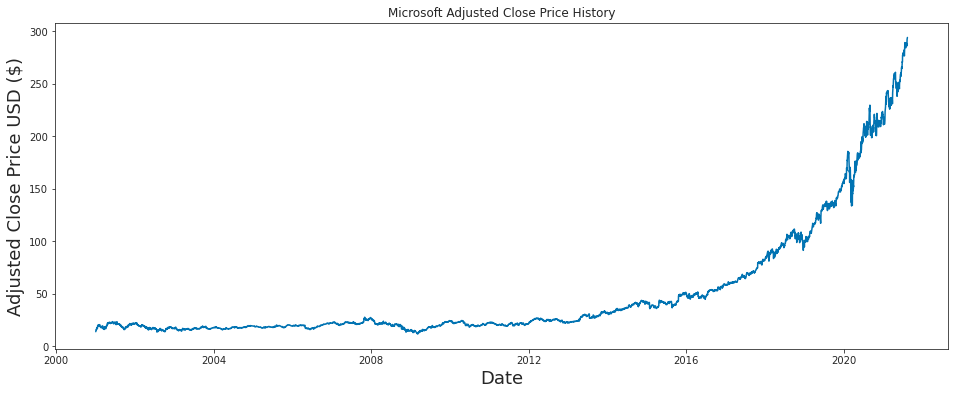

In [71]:
# plot showing Microsoft historical Adjusted closing prices
plt.figure(figsize=(16,6))
plt.title('Microsoft Adjusted Close Price History')
plt.plot(msft_data['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Close Price USD ($)', fontsize=18)
plt.show()

#### Predicting using Long Short-Term Memory (LSTM) 
[LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory#:~:text=Long%20short%2Dterm%20memory%20(LSTM)%20is%20an%20artificial%20recurrent,networks%2C%20LSTM%20has%20feedback%20connections.&text=A%20common%20LSTM%20unit%20is,gate%20and%20a%20forget%20gate.) is an artificial recurrent neural network (RNN) architecture used in deep learning that is capable of learning long-term dependencies. It processes data passing on information as it propagates forward and have a chain like structure. 

In [72]:
#view the shape
msft_data.shape

(5188, 6)

In [126]:
# create the variables for prediction and split into training and test sets

y = np.log(msft_data['Adj Close'].astype(int)) # we want to predict the adjusted close price
X = msft_data.drop('Adj Close', axis=1) # predictive variables (removing Adj close from it)

#split the data into training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42)

In [127]:
# Build the LSTM model for Microsoft stock
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (xtrain.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [128]:
# view model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1625      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [129]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#### Initial parameters used for LSTM

In [130]:
# Train the model - part 1
model.fit(np.array(xtrain).reshape(-1,5,1), ytrain, batch_size =1, epochs=5, verbose=0)

In [131]:
#predictions 
predictions = model.predict(np.array(xtest).reshape(-1,5,1))

In [132]:
#calculation of the mean absolute error
mean_abs_error3 = mean_absolute_error(ytest, predictions)
mean_abs_error3

0.09422255042073428

In [133]:
# Train the model - part 2
model.fit(np.array(xtrain).reshape(-1,5,1), ytrain, batch_size =100, epochs=10, verbose=0)

In [134]:
#predictions 2
predictions = model.predict(np.array(xtest).reshape(-1,5,1))

In [135]:
#calculation of the mean absolute error 2
mean_abs_error3 = mean_absolute_error(ytest, predictions)
mean_abs_error3

0.05984599727633722

### LSTM Refinement
#### Final Parameters used to tune LSTM

In [136]:
# Build the LSTM model with the relu activation function
model2 = Sequential()
model2.add(LSTM(128, activation='relu', return_sequences=True, input_shape= (xtrain.shape[1], 1)))
model2.add(LSTM(64, activation='relu', return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))

In [137]:
# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

In [138]:
# view model2 summary
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1625      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [139]:
# Train the model - part 3
model2.fit(np.array(xtrain).reshape(-1,5,1), ytrain, batch_size =1, epochs=5, verbose=0)

In [140]:
#predictions 3
predictions2 = model2.predict(np.array(xtest).reshape(-1,5,1))

In [141]:
#calculation of the mean absolute error 2
mean_abs_error2 = mean_absolute_error(ytest, predictions)
mean_abs_error2

0.05984599727633722

In [142]:
# Train the model - part 4 (increasing no. of epochs and batch_size)
model2.fit(np.array(xtrain).reshape(-1,5,1), ytrain, batch_size =100, epochs=10, verbose=0)

In [143]:
#predictions 3
predictions2 = model2.predict(np.array(xtest).reshape(-1,5,1))

In [144]:
#calculation of the mean absolute error 2
mean_abs_error2 = mean_absolute_error(ytest, predictions)
mean_abs_error2

0.05984599727633722

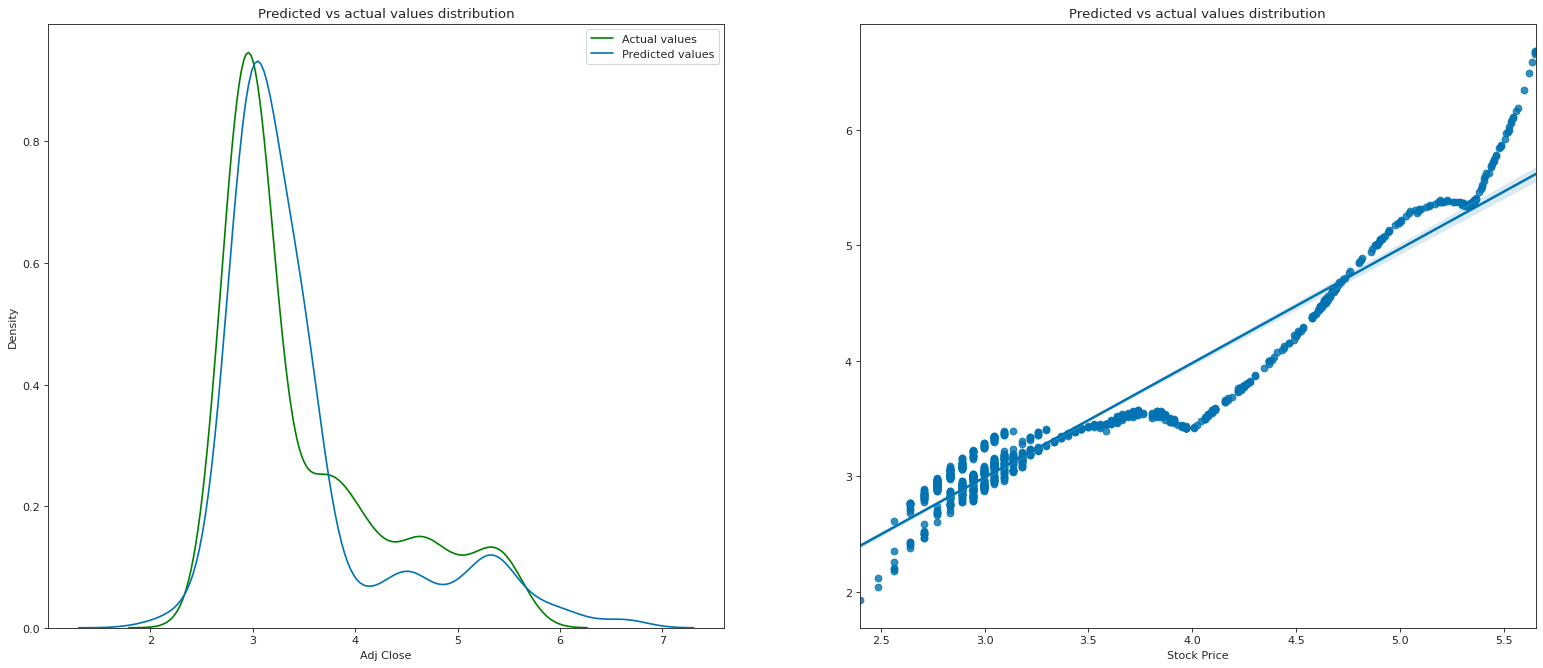

Mean absolute error of <keras.engine.sequential.Sequential object at 0x7f8914f716d8>: 0.05984599727633722


In [145]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=ytest, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predictions2, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=ytest, y=predictions2)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model,mean_abs_error3))

In [146]:
# Train the model part 5 (no activation function)
model.fit(np.array(xtrain).reshape(-1,5,1), ytrain, batch_size =800, epochs=50, verbose=0)

In [147]:
#predictions 
predictions = model.predict(np.array(xtest).reshape(-1,5,1))

In [148]:
#calculation of the mean absolute error
mean_abs_error3 = mean_absolute_error(ytest, predictions)
mean_abs_error3

0.059102257928427444

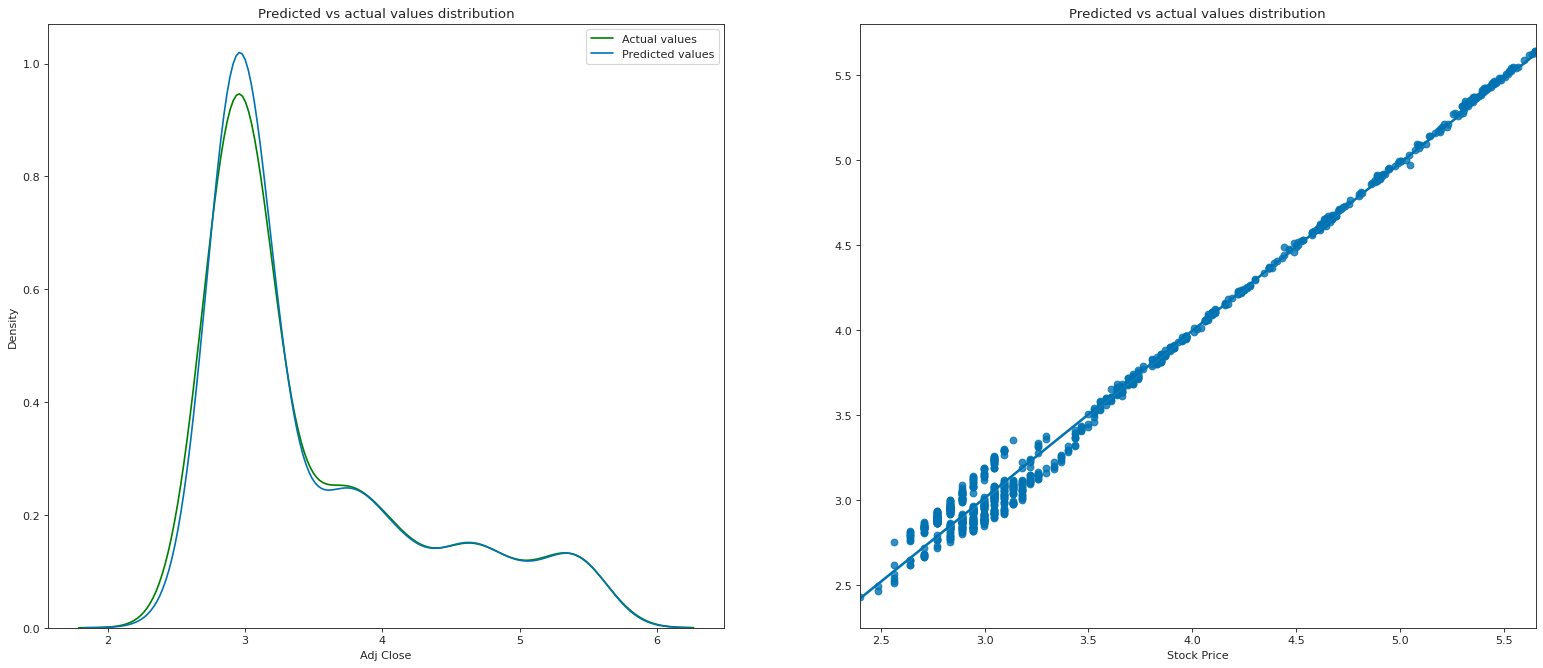

Mean absolute error of <keras.engine.sequential.Sequential object at 0x7f8914f716d8>: 0.059102257928427444


In [149]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=ytest, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predictions, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=ytest, y=predictions)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model,mean_abs_error3))

From the above, we can see that the model is trained and evaluated using `LSTM`. The predicted and actual adjustable stock prices plots look are relatively similar with a mean absolute error of 0.0591 which isn't bad. However, there is still room for improvement and trying out other models to compare.

#### Predicting using Linear Regression

In [157]:
#view the shape
msft_data.tail()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2021-08-10,285.892700,286.440002,289.250000,285.200012,288.799988,18616600.0
2021-08-11,286.401733,286.950012,288.660004,285.859985,287.209991,13955900.0
2021-08-12,289.256256,289.809998,289.970001,286.339996,286.630005,14561300.0
2021-08-13,292.290436,292.850006,292.899994,289.299988,289.480011,18231400.0
2021-08-16,294.037109,294.600006,294.820007,290.019989,293.190002,22507600.0


In [158]:
# Building the model for Adj close prediction

y = np.log(msft_data['Adj Close'].astype(int)) # we want to predict the adjusted close price
X = msft_data.drop('Adj Close', axis=1) # predictive variables (removing Adj close from it)

#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (4150, 5)
y_train (4150,)
x_test (1038, 5)
y_test (1038,)


In [159]:
#creating an instance of a Linear Regressor 
model_lin = LinearRegression()

#fit the model
model_lin.fit(X_train,y_train)

LinearRegression()

In [160]:
# check the score, coef_ and intercept_ of the model
model_lin.score(X_train,y_train)
model_lin.coef_
model_lin.intercept_

print('The score of the model is {}, the coeficients  are {} and the intercept is {}'.format(model_lin.score(X_train,y_train),model_lin.coef_,model_lin.intercept_))

The score of the model is 0.8941916499776275, the coeficients  are [ 1.59555128e-02  2.35428501e-02 -4.81903689e-02  2.05766318e-02
 -5.09686043e-09] and the intercept is 3.0573283973153873


In [161]:
#prediction
predict = model_lin.predict(X_test)
predict #view some predictions

array([3.40239435, 4.7203523 , 3.32116329, ..., 3.97400856, 3.48029585,
       3.45700287])

In [162]:
#calculation of the mean absolute error
mean_abs_error = mean_absolute_error(y_test, predict)
mean_abs_error

0.2153062540986279

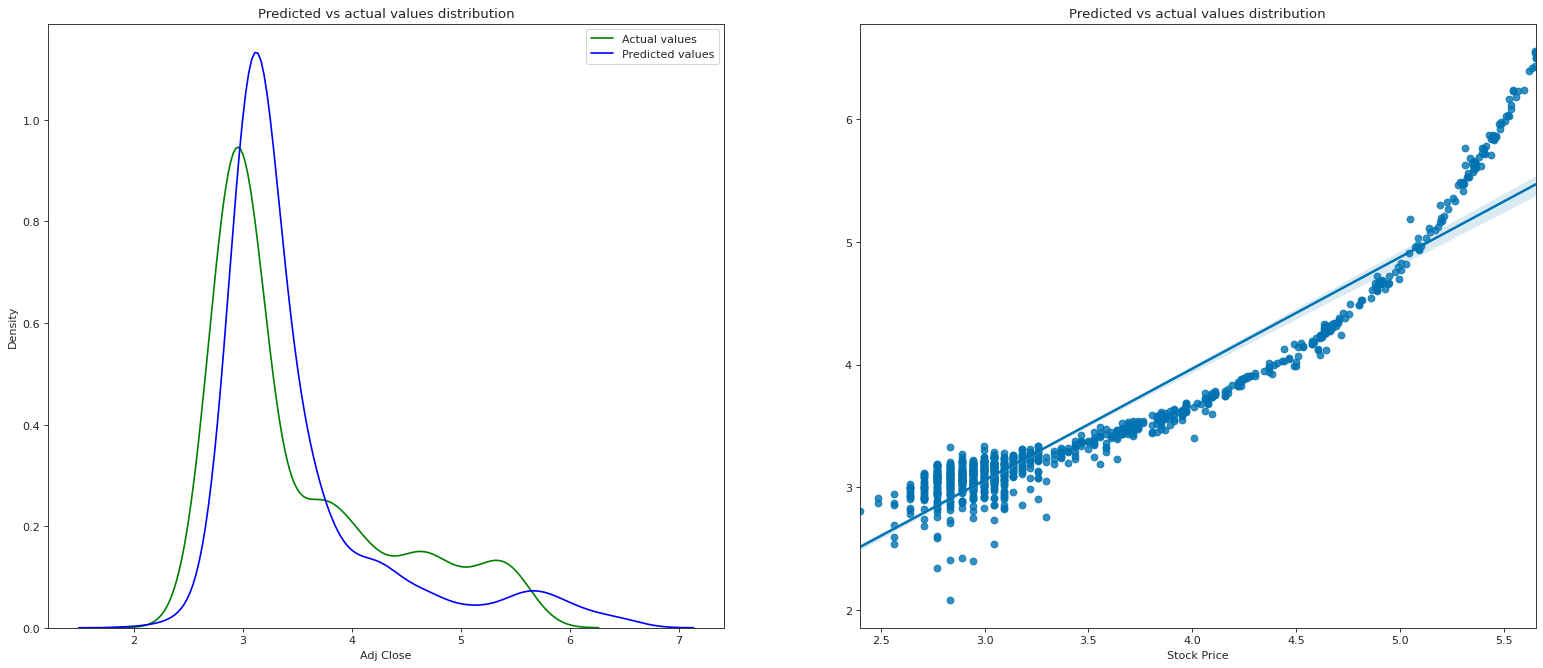

Mean absolute error of LinearRegression(): 0.2153062540986279


In [163]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predict, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=y_test, y=predict)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model_lin,mean_abs_error))

From the above, we can see that the model is trained and evaluated using `LinearRegression`. The predicted and actual adjustable stock prices plots have variations but with a mean absolute error is 0.215 which abit worst than the LSTM model. However, there is still room for improvement and trying out other models to compare. Let't try out another model and see how it performs.

#### Predicting  using Random Forest Regressor

In [164]:
# Building the model for Adj close prediction

y = np.log(msft_data['Adj Close'].astype(int)) # we want to predict the adjusted close price
X = msft_data.drop('Adj Close', axis=1) # predictive variables (removing Adj close from it)

#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (4150, 5)
y_train (4150,)
x_test (1038, 5)
y_test (1038,)


In [165]:
#creating an instance of a Random Forest Regressor 
model_rf = RandomForestRegressor(n_estimators=100, random_state=47)

In [166]:
#fit the model with the training data
model_rf.fit(X_train,y_train)

RandomForestRegressor(random_state=47)

In [167]:
#prediction
predict = model_rf.predict(X_test)
predict #view some predictions

array([3.52576347, 4.8934186 , 3.58680682, ..., 4.37007038, 3.71131998,
       3.71569919])

In [168]:
#calculation of the mean absolute error
mean_abs_error = mean_absolute_error(y_test, predict)
mean_abs_error

0.04943098424812481

In [169]:
# view predictions and actual values
#print(np.c_[y_test,predict])
display_ = pd.DataFrame({'Actual value': y_test, 'Predicted value':predict})
display_.head(10)
#print(y_test,predict)

,Actual value,Predicted value
Date,,
2014-05-16,3.526361,3.525763
2019-07-31,4.890349,4.893419
2015-02-03,3.583519,3.586807
2002-11-20,2.833213,2.904483
2008-02-14,3.044522,3.034989
2010-03-04,3.091042,3.073154
2015-09-09,3.637586,3.634583
2021-07-28,5.652489,5.654322
2009-09-25,2.944439,2.916482


From the table, we can see that the `RandomForestRegressor` performed very well and the actual and predicted Adjusted close value are fairly close. Let us now view the plots.

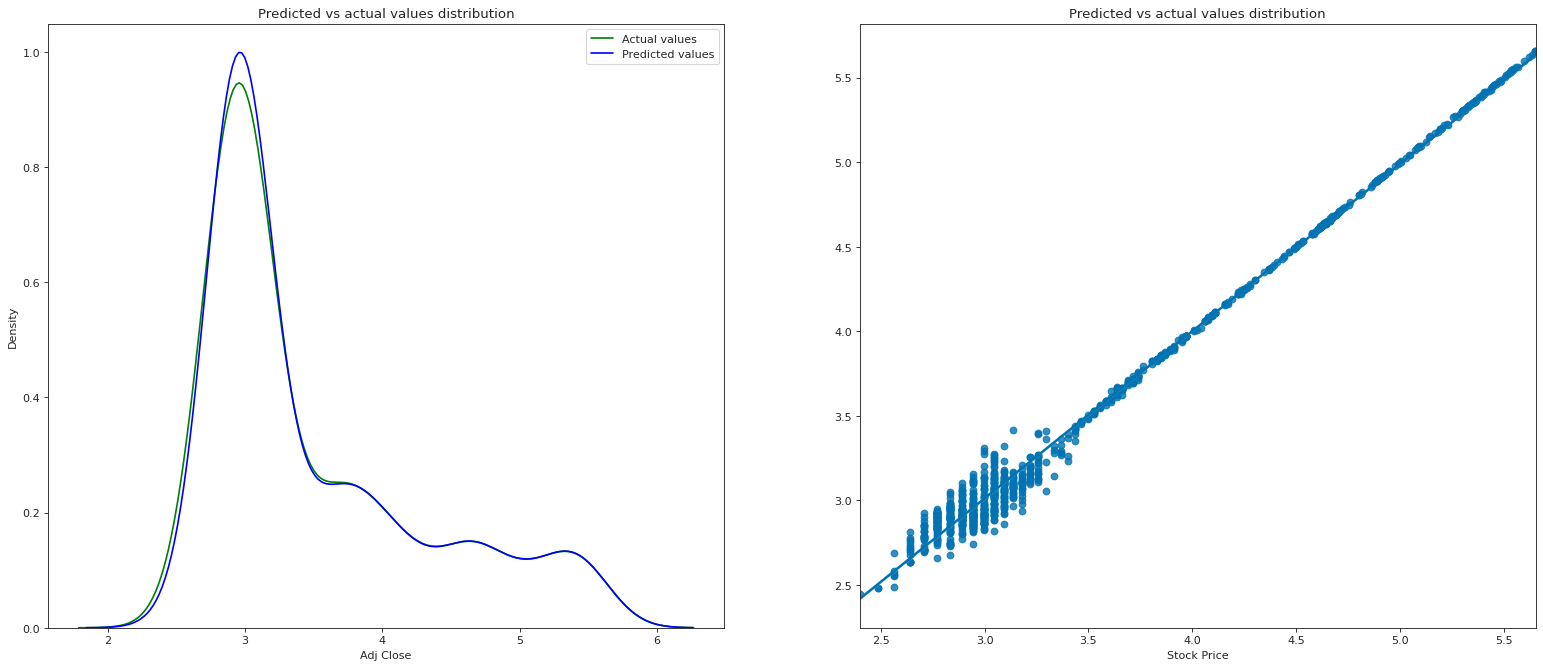

Mean absolute error of RandomForestRegressor(random_state=47): 0.04943098424812481


In [170]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predict, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=y_test, y=predict)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model_rf,mean_abs_error))

From the above, we can see that the model is trained and evaluated using `RandomForestRegressor`. The predicted and actual adjustable stock prices plots look are relatively similar with a mean absolute error is 0.0494 which is good. Let us see how our three models would perfomr with the Google stocks.

### Predicting Adjusted close value of Google stocks

In [171]:
# get Google data and view the first 5 rows
googl_data = get_data(fin_data, 'GOOGL')  
googl_data.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2001-01-02,50.220219,50.220219,52.082081,48.028027,50.050049,44659096.0
2001-01-03,50.220219,50.220219,52.082081,48.028027,50.050049,44659096.0
2001-01-04,50.220219,50.220219,52.082081,48.028027,50.050049,44659096.0
2001-01-05,50.220219,50.220219,52.082081,48.028027,50.050049,44659096.0
2001-01-08,50.220219,50.220219,52.082081,48.028027,50.050049,44659096.0


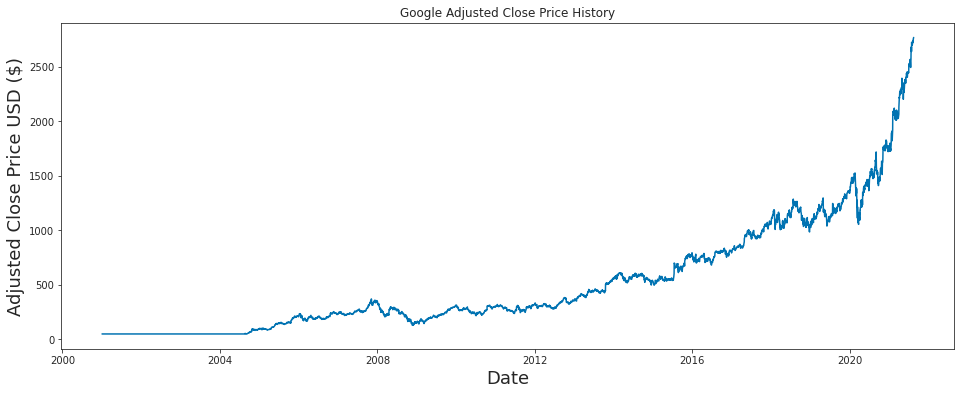

In [172]:
# plot showing Google historical Adjusted closing prices
plt.figure(figsize=(16,6))
plt.title('Google Adjusted Close Price History')
plt.plot(googl_data['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Close Price USD ($)', fontsize=18)
plt.show()

In [173]:
# Building the model for Adj close prediction

# create the variables for prediction and split into training and test sets

y = np.log(googl_data['Adj Close'].astype(int)) # we want to predict the adjusted close price
X = googl_data.drop('Adj Close', axis=1) # predictive variables (removing Adj close from it)

#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (4150, 5)
y_train (4150,)
x_test (1038, 5)
y_test (1038,)


#### Prediction Using LSTM

In [174]:
#### LSTM Model for Google stocks

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model part 5 (no activation function)
model.fit(np.array(X_train).reshape(-1,5,1), y_train, batch_size =800, epochs=50, verbose=0)

#predictions 
predictions = model.predict(np.array(X_test).reshape(-1,5,1))

#calculation of the mean absolute error
mean_abs_error = mean_absolute_error(y_test, predictions)
mean_abs_error

0.006455543812207358

#### Prediction Using Linear Regression

In [175]:
#creating an instance of a Linear Regressor 
model_lin2 = LinearRegression()

#fit the model
model_lin2.fit(X_train,y_train)

#prediction
predict = model_lin2.predict(X_test)

#calculation of the mean absolute error
mean_abs_error = mean_absolute_error(y_test, predict)
mean_abs_error

0.16725238813842158

#### Prediction Using Random Forest Regressor

In [176]:
#creating an instance of a Random Forest Regressor 
model_rf2 = RandomForestRegressor(n_estimators=100, random_state=47)

#fit the model with the training data
model_rf2.fit(X_train,y_train)

#prediction
predict2 = model_rf2.predict(X_test)
predict2 #view some predictions

#calculation of the mean absolute error
mean_abs_error2 = mean_absolute_error(y_test, predict2)
mean_abs_error2

0.0008237543253277643

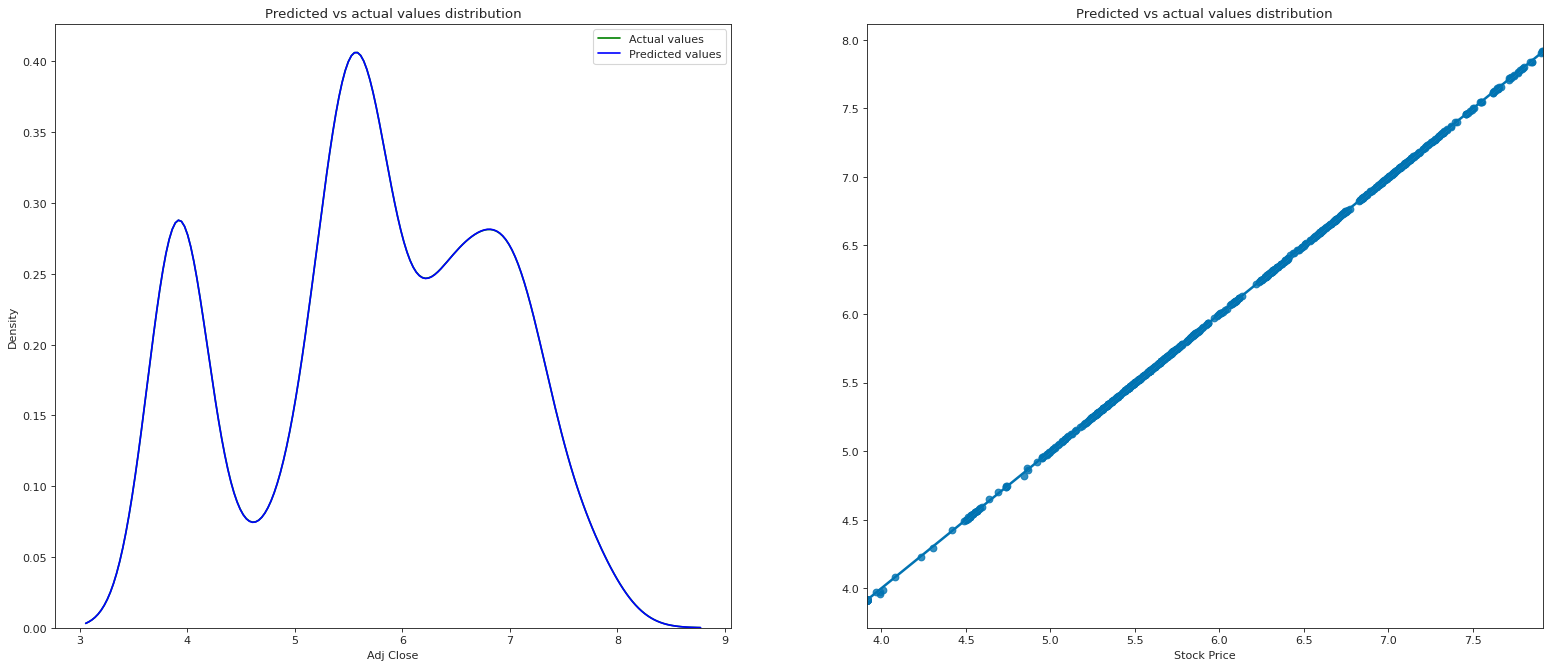

Mean absolute error of RandomForestRegressor(random_state=47): 0.0008237543253277643


In [177]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predict2, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=y_test, y=predict2)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model_rf2,mean_abs_error2))

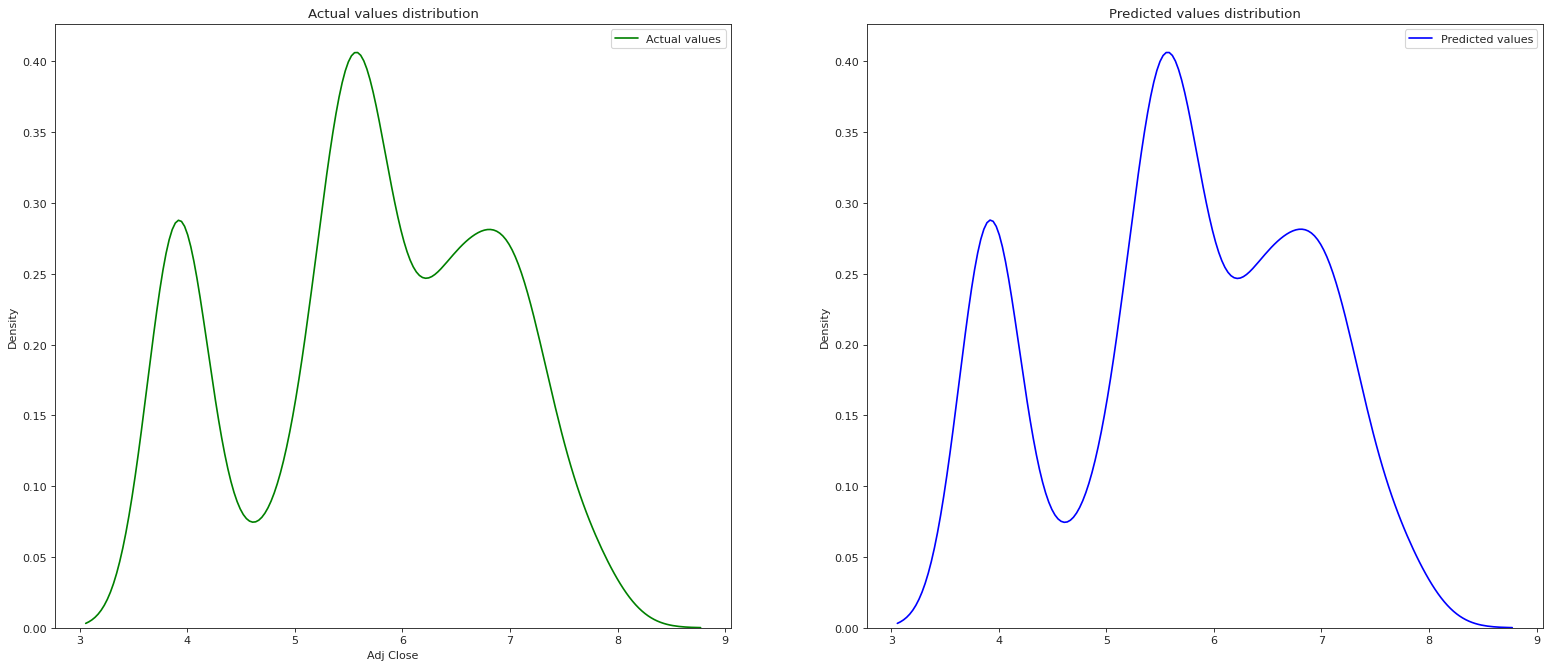

Mean absolute error of RandomForestRegressor(random_state=47): 0.0008237543253277643


In [178]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Actual values distribution')
axs[1].set_title('Predicted values distribution')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predict2, color="b", label='Predicted values', ax=axs[1])

ax1.legend()
ax2.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model_rf2,mean_abs_error2))

From the above, we can see that the model is trained and evaluated using `RandomForestRegressor`. The predicted and actual adjustable Google stock prices plots look are very similar with a mean absolute error is 0.000824 which is very good. We can also see that all three models perform better with Google than Microsoft stocks.

## 4. Results

### Evaluation and Validation of models
From my investigation of three different models, I observed that RandomForestRegressor delivered a much lower mean absolute error (0.0497, 0.000824) than the LSTM (0.0942, 0.00646) or LinearRegression (0.215, 0.167) for Microsoft and Google respectively.  I also observed that tunning the parameters for LSTM (e.g the number of epochs and batch_size) resulted in better prediction.

### Interesting facts about the project
When exploring the data, it was interesting to see how the stock prices of different companies changed due to the pandemic and how the technological companies stock prices bounced back more quickly than the other companies considered. It was also interesting to see how Pfizer stocks improved as the vaccine rollout began.

Here are some major highlights from the data exploration section:

  1. 2019: Before the pandemic, most of the companies stocks were doing relatively well with Apple and Microsoft taking the lead and Pfizer trailing behind.
  2. 2020: On the onset of the pandemic around Spring, there was a fall in stock prices for all the companies, but afterwards the technology companies like Amazon, Apple, Microsoft and Google started to grow again. But companies like Pfizer, Ford and S&P 500 did not do very well especially Ford.
  3. 2021: As the vaccine rollout began and the lockdown began to be lifted, there was significant growth in the stock prices of Ford in particular given its very stock prices which was low in 2020 due to the pandemic. Companies like Google and Microsoft,S&P 500 also grew. Overall there was an improvement in the stock prices of all the companies we considered.

### Difficulties encountered
1. Getting the data from yahoo fincance wasn't very obvious. After several research I was able to find an [article](https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e) that guided me on how to obtain the data.
2. The [Machine Learning for Trading course](https://www.udacity.com/course/machine-learning-for-trading--ud501) was also really helpful to knowing more about financial data and how to handle it as well as knowing where to begin my data exploration.
3. In the modelling part (particularly the LSTM), one would have to spend some time tuning the parameters and training it  to get the best results.

### Improvements
An improvement to my analysis could be the following:
1. Take some significant time to tune the model parameters as well as include more features that might be relevant for stock price prediction.
2. Try out more models and see if there might be one with a better performance than the RandomForestRegressor. I only tried three models for simplicity and time constraints. 
3. Explore other companies stocks to see how well one can predict their stocks prices with different models.